In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("🔄 Loading FD001 data...")
# Column names: unit, cycle, 3 settings, 21 sensors
col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# Load train_FD001.txt
train_df = pd.read_csv('data1/train_FD001.txt', sep='\s+', header=None, names=col_names)
print(f"✅ Successfully loaded: {train_df.shape}")


🔄 Loading FD001 data...
✅ Successfully loaded: (20631, 26)


In [2]:
# Calculate RUL = max_cycle_per_unit - current_cycle
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']

print("✅ RUL calculated")
print("Sample RUL per unit:")
print(train_df.groupby('unit')['RUL'].first().head())


✅ RUL calculated
Sample RUL per unit:
unit
1    191
2    286
3    178
4    188
5    268
Name: RUL, dtype: int64


In [3]:
# Normalize 21 sensors only (settings stay unscaled)
scaler = MinMaxScaler()
sensor_cols = [f'sensor{i}' for i in range(1,22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

print("✅ Sensors normalized (0-1)")
print(f"Sensor 1 range: {train_df['sensor1'].min():.3f} to {train_df['sensor1'].max():.3f}")


✅ Sensors normalized (0-1)
Sensor 1 range: 0.000 to 0.000


In [4]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    sensor_cols = [f'sensor{i}' for i in range(1,22)]
    
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

print("🔄 Creating sequences...")
X_fd001, y_fd001 = create_sequences(train_df)
print(f"✅ Sequences: X({X_fd001.shape}), y({y_fd001.shape})")


🔄 Creating sequences...
✅ Sequences: X((17631, 30, 21)), y((17631,))


In [5]:
# Save ALL artifacts
np.savez_compressed('fd001_sequences.npz', X=X_fd001, y=y_fd001)
np.save('fd001_scaler.npy', scaler)
train_df.to_csv('fd001_preprocessed.csv', index=False)

print("🎉 MILESTONE 1 COMPLETE!")
print("✅ Files saved:")


🎉 MILESTONE 1 COMPLETE!
✅ Files saved:


In [6]:
from sklearn.model_selection import train_test_split

# Split data: 60% train, 20% val, 20% test
X_temp, X_val, y_temp, y_val = train_test_split(X_fd001, y_fd001, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ Splits created:")
print(f"   Train: X({X_train.shape}), y({y_train.shape})")
print(f"   Val:   X({X_val.shape}), y({y_val.shape})")
print(f"   Test:  X({X_test.shape}), y({y_test.shape})")


✅ Splits created:
   Train: X((7052, 30, 21)), y((7052,))
   Val:   X((3527, 30, 21)), y((3527,))
   Test:  X((7052, 30, 21)), y((7052,))


In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model():
    model = Sequential([
        tf.keras.layers.Input(shape=(30, 21)),
        GRU(50, return_sequences=True),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model = build_gru_model()
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train the model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_val, y_val),
    verbose=1
)

print("✅ Model training phase COMPLETE!")




Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 22ms/step - loss: 6277.9336 - val_loss: 3733.9036
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 3877.0840 - val_loss: 3731.2942
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 2430.4365 - val_loss: 1404.6080
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 1306.2299 - val_loss: 1054.2134
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 1141.3374 - val_loss: 1043.6655
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1104.0463 - val_loss: 1067.9200
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1060.0880 - val_loss: 1029.9763
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1043.7843 - val_loss: 1007.3208
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - loss: 1040.0842 - val_loss: 1013.2289
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 1013.5974 - val_loss: 966.2807
Epoch 11/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1020.110

In [9]:
# Quick validation check
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ Validation RMSE: {val_rmse:.2f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ Validation RMSE: 27.79


In [10]:
# FIXED: Save weights with .weights.h5 extension
model.save_weights('fd001_gru_model.weights.h5')

# Save splits (unchanged)
np.savez_compressed('fd001_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)

print("🎉 MILESTONE 2 COMPLETED!")
print("✅ Files saved:")


🎉 MILESTONE 2 COMPLETED!
✅ Files saved:


In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Test predictions
y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ Test RMSE: {test_rmse:.2f}")
print(f"✅ Test MAE: {test_mae:.2f}")


221/221 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
✅ Test RMSE: 28.50
✅ Test MAE: 19.18


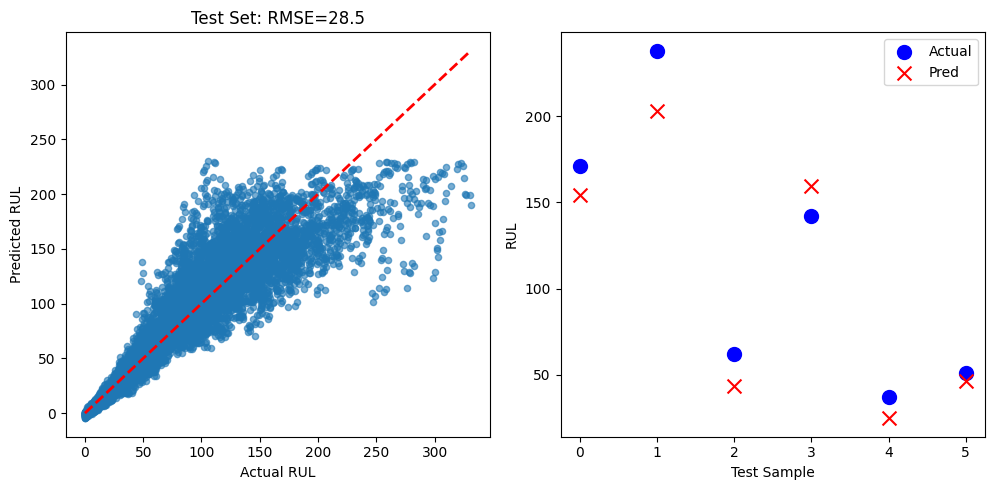

Text(0.5, 1.0, 'Error Dist\nMean: -0.1')

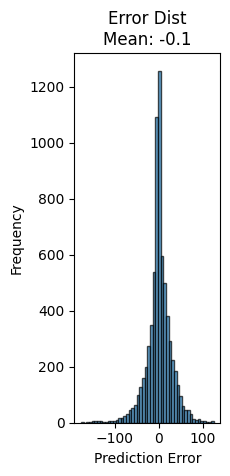

In [12]:
plt.figure(figsize=(15, 5))

# Plot 1: Predicted vs Actual RUL
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'Test Set: RMSE={test_rmse:.1f}')

# Plot 2: Sample Predictions
plt.subplot(1, 3, 2)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.savefig('fd001_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot 3: Error Distribution
plt.subplot(1, 3, 3)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')



In [13]:
# Save for dashboard
np.savez('fd001_evaluation.npz', y_test=y_test, y_test_pred=y_test_pred, 
         rmse=test_rmse, mae=test_mae)

print("🎉 MILESTONE 3 COMPLETE!")
print("✅ Files saved:")


🎉 MILESTONE 3 COMPLETE!
✅ Files saved:


In [14]:
# Alert thresholds
def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alerts = [classify_alert(p) for p in y_test_pred]
print("Alert Distribution:")
print(pd.Series(alerts).value_counts())


Alert Distribution:
SAFE         3419
VERY_SAFE    2340
WARNING       815
CRITICAL      478
Name: count, dtype: int64


In [15]:
import pandas as pd
import numpy as np

# Load test predictions (from MILESTONE 3)
data_eval = np.load('fd001_evaluation.npz')
y_test = data_eval['y_test']
y_test_pred = data_eval['y_test_pred']

# Define RUL thresholds (in cycles)
THRESHOLDS = {
    'critical': 10,   # very close to failure
    'warning': 30,    # approaching failure
    'safe': 125       # normal range
}

def classify_alert(rul):
    if rul < THRESHOLDS['critical']:
        return 'CRITICAL'
    elif rul < THRESHOLDS['warning']:
        return 'WARNING'
    elif rul < THRESHOLDS['safe']:
        return 'SAFE'
    else:
        return 'VERY_SAFE'

# Apply to all test predictions
alert_levels = [classify_alert(r) for r in y_test_pred]

# Build a DataFrame for analysis
df_alerts = pd.DataFrame({
    'actual_rul': y_test,
    'predicted_rul': y_test_pred,
    'alert_level': alert_levels
})

df_alerts.head()


,actual_rul,predicted_rul,alert_level
0,171,154.034943,VERY_SAFE
1,142,131.857071,VERY_SAFE
2,199,167.807327,VERY_SAFE
3,141,115.709923,SAFE
4,113,102.671593,SAFE


In [16]:
print("Alert level counts:")
print(df_alerts['alert_level'].value_counts())

# Basic check: average actual RUL per alert level
print("Average ACTUAL RUL per alert level:")
print(df_alerts.groupby('alert_level')['actual_rul'].mean().round(2))


Alert level counts:
alert_level
SAFE         3419
VERY_SAFE    2340
WARNING       815
CRITICAL      478
Name: count, dtype: int64
Average ACTUAL RUL per alert level:
alert_level
CRITICAL       6.33
SAFE          80.31
VERY_SAFE    156.26
WARNING       22.89
Name: actual_rul, dtype: float64


In [17]:
# Save alerts and thresholds for later (dashboard)
np.savez(
    'fd001_alerts.npz',
    actual_rul=y_test,
    predicted_rul=y_test_pred,
    alert_level=np.array(alert_levels, dtype=object),
    thresholds=np.array(list(THRESHOLDS.items()), dtype=object)
)

print("🎉 MILESTONE 4 COMPLETE!")
print("✅ File saved:")


🎉 MILESTONE 4 COMPLETE!
✅ File saved:


In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

print("🔄 FD002 Step 1: Loading data...")

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]

# FD002 file
train_df_2 = pd.read_csv('data2/train_FD002.txt',
                         sep=r'\s+',
                         header=None,
                         names=col_names)

print(f"✅ FD002 Successfully loaded: {train_df_2.shape}")
train_df_2.head()


🔄 FD002 Step 1: Loading data...
✅ FD002 Successfully loaded: (53759, 26)


,unit,cycle,setting1,setting2,setting3,sensor1,sensor2,sensor3,sensor4,sensor5,...,sensor12,sensor13,sensor14,sensor15,sensor16,sensor17,sensor18,sensor19,sensor20,sensor21
0,1,1,34.9983,0.8400,100.0,449.44,555.32,1358.61,1137.23,5.48,...,183.06,2387.72,8048.56,9.3461,0.02,334,2223,100.00,14.73,8.8071
1,1,2,41.9982,0.8408,100.0,445.00,549.90,1353.22,1125.78,3.91,...,130.42,2387.66,8072.30,9.3774,0.02,330,2212,100.00,10.41,6.2665
2,1,3,24.9988,0.6218,60.0,462.54,537.31,1256.76,1047.45,7.05,...,164.22,2028.03,7864.87,10.8941,0.02,309,1915,84.93,14.08,8.6723
3,1,4,42.0077,0.8416,100.0,445.00,549.51,1354.03,1126.38,3.91,...,130.72,2387.61,8068.66,9.3528,0.02,329,2212,100.00,10.59,6.4701
4,1,5,25.0005,0.6203,60.0,462.54,537.07,1257.71,1047.93,7.05,...,164.31,2028.00,7861.23,10.8963,0.02,309,1915,84.93,14.13,8.5286


In [19]:
# Calculate RUL for each unit
max_cycles_2 = train_df_2.groupby('unit')['cycle'].max().reset_index()
max_cycles_2.columns = ['unit', 'max_cycle']

train_df_2 = train_df_2.merge(max_cycles_2, on='unit')
train_df_2['RUL'] = train_df_2['max_cycle'] - train_df_2['cycle']

print("✅ FD002 RUL calculated")
train_df_2[['unit', 'cycle', 'RUL']].head()


✅ FD002 RUL calculated


,unit,cycle,RUL
0,1,1,148
1,1,2,147
2,1,3,146
3,1,4,145
4,1,5,144


In [20]:
# Normalize 21 sensor columns
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler_2 = MinMaxScaler()
train_df_2[sensor_cols] = scaler_2.fit_transform(train_df_2[sensor_cols])

print("✅ FD002 sensors normalized")
print(train_df_2[sensor_cols].describe().T[['min', 'max']].head())


✅ FD002 sensors normalized
         min  max
sensor1  0.0  1.0
sensor2  0.0  1.0
sensor3  0.0  1.0
sensor4  0.0  1.0
sensor5  0.0  1.0


In [21]:
def create_sequences_fd2(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

print("🔄 Creating FD002 sequences...")
X_fd002, y_fd002 = create_sequences_fd2(train_df_2, seq_length=30)
print(f"✅ FD002 sequences: X{X_fd002.shape}, y{y_fd002.shape}")


🔄 Creating FD002 sequences...
✅ FD002 sequences: X(45959, 30, 21), y(45959,)


In [22]:
np.savez_compressed('fd002_sequences.npz', X=X_fd002, y=y_fd002)
np.save('fd002_scaler.npy', scaler_2)
train_df_2.to_csv('fd002_preprocessed.csv', index=False)

print("🎉 FD002 Milestone 1 COMPLETE!")
print(" Files saved:")


🎉 FD002 Milestone 1 COMPLETE!
 Files saved:


In [23]:
from sklearn.model_selection import train_test_split

X2_temp, X2_val, y2_temp, y2_val = train_test_split(
    X_fd002, y_fd002, test_size=0.2, random_state=42
)
X2_train, X2_test, y2_train, y2_test = train_test_split(
    X2_temp, y2_temp, test_size=0.5, random_state=42
)

print("✅ FD002 Splits:")
print(f"  Train: X{X2_train.shape}, y{y2_train.shape}")
print(f"  Val:   X{X2_val.shape}, y{y2_val.shape}")
print(f"  Test:  X{X2_test.shape}, y{y2_test.shape}")


✅ FD002 Splits:
  Train: X(18383, 30, 21), y(18383,)
  Val:   X(9192, 30, 21), y(9192,)
  Test:  X(18384, 30, 21), y(18384,)


In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def build_gru_model_fd2(seq_length=30, n_features=21):
    model = Sequential([
        tf.keras.layers.Input(shape=(seq_length, n_features)),
        GRU(50, return_sequences=True),
        Dropout(0.2),
        GRU(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

model_fd2 = build_gru_model_fd2()
model_fd2.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [25]:
history_fd2 = model_fd2.fit(
    X2_train, y2_train,
    epochs=50,
    batch_size=32,
    validation_data=(X2_val, y2_val),
    verbose=1
)

print("✅ FD002 training complete")


Epoch 1/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 12s 17ms/step - loss: 4737.4331 - val_loss: 3866.6736
Epoch 2/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 3870.0220 - val_loss: 3868.8054
Epoch 3/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - loss: 3854.0178 - val_loss: 3866.4683
Epoch 4/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 3870.7480 - val_loss: 3865.4016
Epoch 5/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 3858.5322 - val_loss: 3867.4856
Epoch 6/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 3653.1052 - val_loss: 2876.0322
Epoch 7/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2520.0229 - val_loss: 2247.2126
Epoch 8/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 16ms/step - loss: 2264.2747 - val_loss: 3885.4231
Epoch 9/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 9s 15ms/step - loss: 2078.4922 - val_loss: 1867.0359
Epoch 10/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1869.6659 - val_loss: 1680.6727
Epoch 11/50
575/575 ━━━━━━━━━━━━━━━━━━━━ 8s 14ms/step - loss: 1776.3

In [26]:
y2_val_pred = model_fd2.predict(X2_val)
val_rmse_fd2 = np.sqrt(np.mean((y2_val_pred.flatten() - y2_val)**2))
print(f"✅ FD002 Validation RMSE: {val_rmse_fd2:.2f}")


288/288 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
✅ FD002 Validation RMSE: 19.61


In [27]:
# Save weights
model_fd2.save_weights('fd002_gru_model.weights.h5')

# Save splits
np.savez_compressed(
    'fd002_splits.npz',
    X_train=X2_train, X_val=X2_val, X_test=X2_test,
    y_train=y2_train, y_val=y2_val, y_test=y2_test
)

print("🎉Milestone 2 COMPLETE!")
print(" Files saved:")


🎉Milestone 2 COMPLETE!
 Files saved:


In [28]:
from sklearn.metrics import mean_squared_error

y2_test_pred = model_fd2.predict(X2_test).flatten()
test_rmse_fd2 = np.sqrt(mean_squared_error(y2_test, y2_test_pred))
test_mae_fd2 = np.mean(np.abs(y2_test - y2_test_pred))

print(f"✅ FD002 Test RMSE: {test_rmse_fd2:.2f}")
print(f"✅ FD002 Test MAE: {test_mae_fd2:.2f}")


575/575 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step
✅ FD002 Test RMSE: 20.07
✅ FD002 Test MAE: 14.61


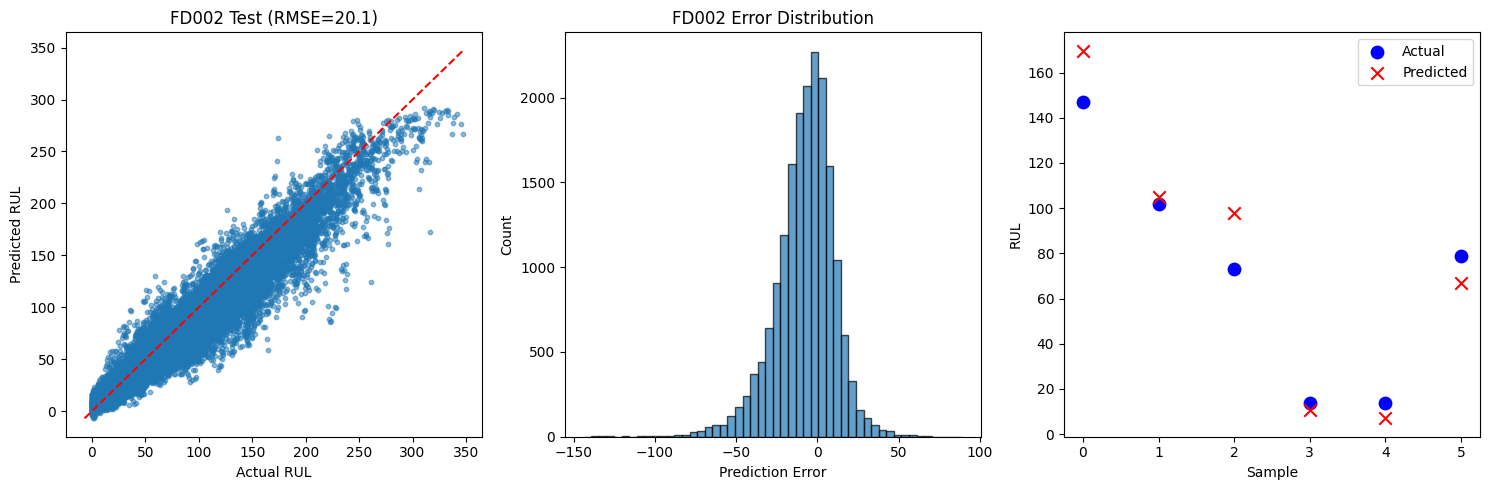

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

# Predicted vs Actual
plt.subplot(1,3,1)
plt.scatter(y2_test, y2_test_pred, alpha=0.5, s=10)
mn, mx = min(y2_test.min(), y2_test_pred.min()), max(y2_test.max(), y2_test_pred.max())
plt.plot([mn, mx], [mn, mx], 'r--')
plt.xlabel("Actual RUL")
plt.ylabel("Predicted RUL")
plt.title(f"FD002 Test (RMSE={test_rmse_fd2:.1f})")

# Error distribution
errors_2 = y2_test_pred - y2_test
plt.subplot(1,3,2)
plt.hist(errors_2, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.title("FD002 Error Distribution")

# Sample predictions
plt.subplot(1,3,3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y2_test[i], c='blue', s=80, label='Actual' if i==0 else "")
    plt.scatter(i//5, y2_test_pred[i], c='red', marker='x', s=80, label='Predicted' if i==0 else "")
plt.xlabel("Sample")
plt.ylabel("RUL")
plt.legend()

plt.tight_layout()
plt.savefig("fd002_evaluation_plots.png", dpi=300, bbox_inches="tight")
plt.show()


In [30]:
np.savez(
    'fd002_evaluation.npz',
    y_test=y2_test,
    y_test_pred=y2_test_pred,
    rmse=test_rmse_fd2,
    mae=test_mae_fd2
)

print("🎉 FD002 Milestone 3 COMPLETE!")
print("File saved:")


🎉 FD002 Milestone 3 COMPLETE!
File saved:


In [31]:
def classify_alert_fd2(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alert_levels_2 = [classify_alert_fd2(r) for r in y2_test_pred]

df_alerts_2 = pd.DataFrame({
    'actual_rul': y2_test,
    'predicted_rul': y2_test_pred,
    'alert_level': alert_levels_2
})

print("FD002 alert distribution:")
print(df_alerts_2['alert_level'].value_counts())

np.savez(
    'fd002_alerts.npz',
    actual_rul=y2_test,
    predicted_rul=y2_test_pred,
    alert_level=np.array(alert_levels_2, dtype=object)
)

print("🎉 FD002 Milestone 4 COMPLETED!")


FD002 alert distribution:
alert_level
SAFE         10715
VERY_SAFE     4350
WARNING       2494
CRITICAL       825
Name: count, dtype: int64
🎉 FD002 Milestone 4 COMPLETED!


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]
train_df = pd.read_csv('data3/train_FD003.txt', sep='\s+', header=None, names=col_names)
print(f"✅ FD003: {train_df.shape}")


✅ FD003: (24720, 26)


In [33]:
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
print("✅ FD003 RUL done")


✅ FD003 RUL done


In [34]:
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler = MinMaxScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
print("✅ FD003 normalized")


✅ FD003 normalized


In [35]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

X_fd003, y_fd003 = create_sequences(train_df)
print(f"✅ FD003 sequences: {X_fd003.shape}")


✅ FD003 sequences: (21720, 30, 21)


In [36]:
np.savez_compressed('fd003_sequences.npz', X=X_fd003, y=y_fd003)
np.save('fd003_scaler.npy', scaler)
print("✅ FD003 Milestone 1 COMPLETED!")


✅ FD003 Milestone 1 COMPLETED!


In [37]:
from sklearn.model_selection import train_test_split

X_temp, X_val, y_temp, y_val = train_test_split(X_fd003, y_fd003, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ FD003 Splits: Train{X_train.shape}, Val{X_val.shape}, Test{X_test.shape}")


✅ FD003 Splits: Train(8688, 30, 21), Val(4344, 30, 21), Test(8688, 30, 21)


In [38]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    tf.keras.layers.Input(shape=(30, 21)),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_4 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_5 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val, y_val), verbose=1)
print("✅ FD003 training complete")


Epoch 1/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 12998.9326 - val_loss: 8467.4043
Epoch 2/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 8999.6367 - val_loss: 8468.5205
Epoch 3/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 7554.6167 - val_loss: 3921.8201
Epoch 4/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3968.4011 - val_loss: 3231.4399
Epoch 5/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 3614.9456 - val_loss: 2896.9058
Epoch 6/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3335.2544 - val_loss: 2698.5735
Epoch 7/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 3191.9304 - val_loss: 2861.6978
Epoch 8/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2990.7805 - val_loss: 2390.5107
Epoch 9/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2891.2468 - val_loss: 2623.1538
Epoch 10/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2780.8093 - val_loss: 2296.2769
Epoch 11/50
272/272 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - loss: 2710.8

In [40]:
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ FD003 Val RMSE: {val_rmse:.2f}")


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
✅ FD003 Val RMSE: 40.79


In [41]:
model.save_weights('fd003_gru_model.weights.h5')
np.savez_compressed('fd003_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)
print("✅ FD003 Milestone 2 COMPLETED!")


✅ FD003 Milestone 2 COMPLETED!


In [42]:
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Test predictions
y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ FD003 Test RMSE: {test_rmse:.2f}")
print(f"✅ FD003 Test MAE: {test_mae:.2f}")


272/272 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
✅ FD003 Test RMSE: 42.45
✅ FD003 Test MAE: 26.69


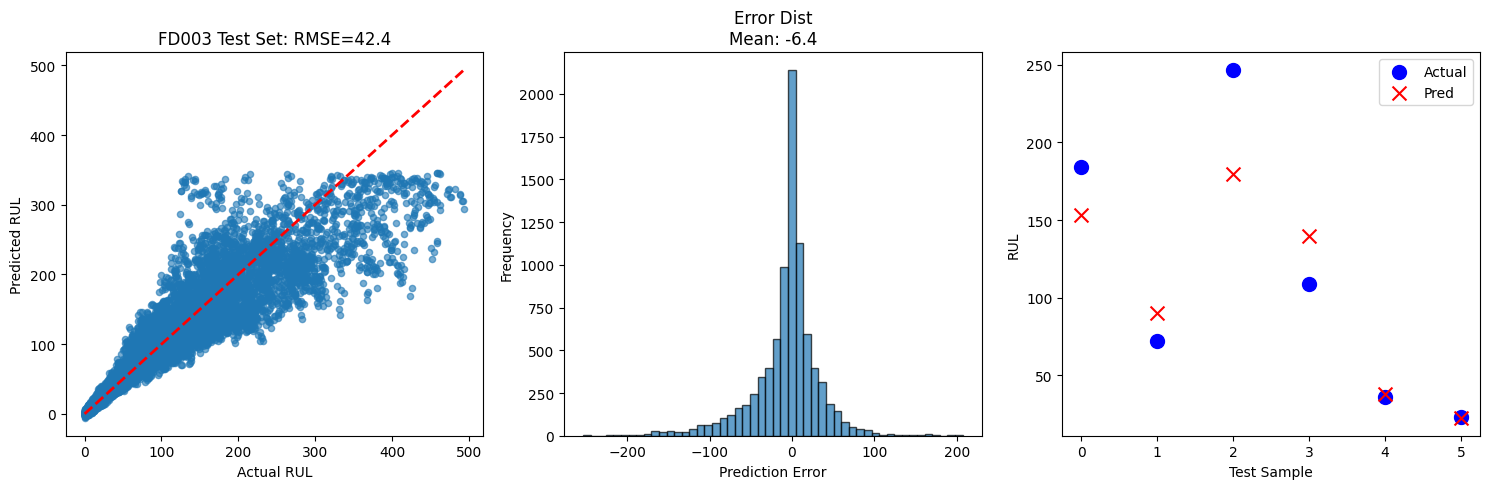

In [43]:
plt.figure(figsize=(15, 5))

# Predicted vs Actual
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'FD003 Test Set: RMSE={test_rmse:.1f}')

# Error Distribution
plt.subplot(1, 3, 2)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')

# Sample Predictions
plt.subplot(1, 3, 3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL'); plt.legend()

plt.tight_layout()
plt.savefig('fd003_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()


In [44]:
np.savez('fd003_evaluation.npz', y_test=y_test, y_test_pred=y_test_pred, 
         rmse=test_rmse, mae=test_mae)
print("✅ FD003 Milestone 3 COMPLETED!")


✅ FD003 Milestone 3 COMPLETED!


In [45]:
def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

alerts = [classify_alert(p) for p in y_test_pred]
print("FD003 Alert Distribution:")
print(pd.Series(alerts).value_counts())

np.savez('fd003_alerts.npz', alerts_df=pd.Series(alerts))
print("✅ FD003 Milestone 4 COMPLETE!")


FD003 Alert Distribution:
SAFE         3909
VERY_SAFE    3634
WARNING       765
CRITICAL      380
Name: count, dtype: int64
✅ FD003 Milestone 4 COMPLETE!


In [46]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

col_names = ['unit', 'cycle'] + [f'setting{i}' for i in range(1,4)] + [f'sensor{i}' for i in range(1,22)]
train_df = pd.read_csv('data4/train_FD004.txt', sep='\s+', header=None, names=col_names)
print(f"✅ FD004: {train_df.shape}")  # Expect: ~65k rows (largest!)


✅ FD004: (61249, 26)


In [47]:
max_cycles = train_df.groupby('unit')['cycle'].max().reset_index()
max_cycles.columns = ['unit', 'max_cycle']
train_df = train_df.merge(max_cycles, on='unit')
train_df['RUL'] = train_df['max_cycle'] - train_df['cycle']
print("✅ FD004 RUL done")


✅ FD004 RUL done


In [48]:
sensor_cols = [f'sensor{i}' for i in range(1,22)]
scaler = MinMaxScaler()
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])
print("✅ FD004 normalized")


✅ FD004 normalized


In [49]:
def create_sequences(df, seq_length=30):
    X, y = [], []
    for unit in df['unit'].unique():
        unit_df = df[df['unit'] == unit].reset_index(drop=True)
        for i in range(seq_length, len(unit_df)):
            X.append(unit_df[sensor_cols].iloc[i-seq_length:i].values)
            y.append(unit_df['RUL'].iloc[i])
    return np.array(X), np.array(y)

X_fd004, y_fd004 = create_sequences(train_df)
print(f"✅ FD004 sequences: {X_fd004.shape}")  # Expect: ~45k sequences


✅ FD004 sequences: (53779, 30, 21)


In [50]:
np.savez_compressed('fd004_sequences.npz', X=X_fd004, y=y_fd004)
np.save('fd004_scaler.npy', scaler)
print("✅ FD004 Milestone 1 COMPLETED!")


✅ FD004 Milestone 1 COMPLETED!


In [51]:
from sklearn.model_selection import train_test_split

X_temp, X_val, y_temp, y_val = train_test_split(X_fd004, y_fd004, test_size=0.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"✅ FD004 Splits: Train{X_train.shape}, Val{X_val.shape}, Test{X_test.shape}")


✅ FD004 Splits: Train(21511, 30, 21), Val(10756, 30, 21), Test(21512, 30, 21)


In [52]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam

model = Sequential([
    tf.keras.layers.Input(shape=(30, 21)),
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_6 (GRU)                     │ (None, 30, 50)         │        10,950 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 30, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_7 (GRU)                     │ (None, 50)             │        15,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,551 (107.62 KB)

 Trainable params: 27,551 (107.62 KB)

 Non-trainable params: 0 (0.00 B)

In [53]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                   validation_data=(X_val, y_val), verbose=1)
print("✅ FD004 training complete")


Epoch 1/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 13s 16ms/step - loss: 8677.4297 - val_loss: 6736.3413
Epoch 2/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 7137.8262 - val_loss: 6735.1675
Epoch 3/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 7156.8042 - val_loss: 6741.2437
Epoch 4/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 7131.7075 - val_loss: 6734.0493
Epoch 5/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 7154.3286 - val_loss: 6724.5845
Epoch 6/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 5876.1660 - val_loss: 4092.3406
Epoch 7/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 4117.9253 - val_loss: 3832.2212
Epoch 8/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - loss: 3737.6848 - val_loss: 3211.0569
Epoch 9/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 3540.9243 - val_loss: 3130.1152
Epoch 10/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 3449.2588 - val_loss: 3030.1311
Epoch 11/50
673/673 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - lo

In [54]:
y_val_pred = model.predict(X_val)
val_rmse = np.sqrt(np.mean((y_val_pred.flatten() - y_val)**2))
print(f"✅ FD004 Val RMSE: {val_rmse:.2f}")


337/337 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
✅ FD004 Val RMSE: 35.75


In [55]:
model.save_weights('fd004_gru_model.weights.h5')
np.savez_compressed('fd004_splits.npz', X_train=X_train, X_val=X_val, X_test=X_test,
                   y_train=y_train, y_val=y_val, y_test=y_test)
print("✅ FD004 Milestone 2 COMPLETED!")


✅ FD004 Milestone 2 COMPLETED!


In [56]:
from sklearn.metrics import mean_squared_error

y_test_pred = model.predict(X_test).flatten()
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_mae = np.mean(np.abs(y_test - y_test_pred))

print(f"✅ FD004 Test RMSE: {test_rmse:.2f}")
print(f"✅ FD004 Test MAE: {test_mae:.2f}")


673/673 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
✅ FD004 Test RMSE: 35.61
✅ FD004 Test MAE: 26.30


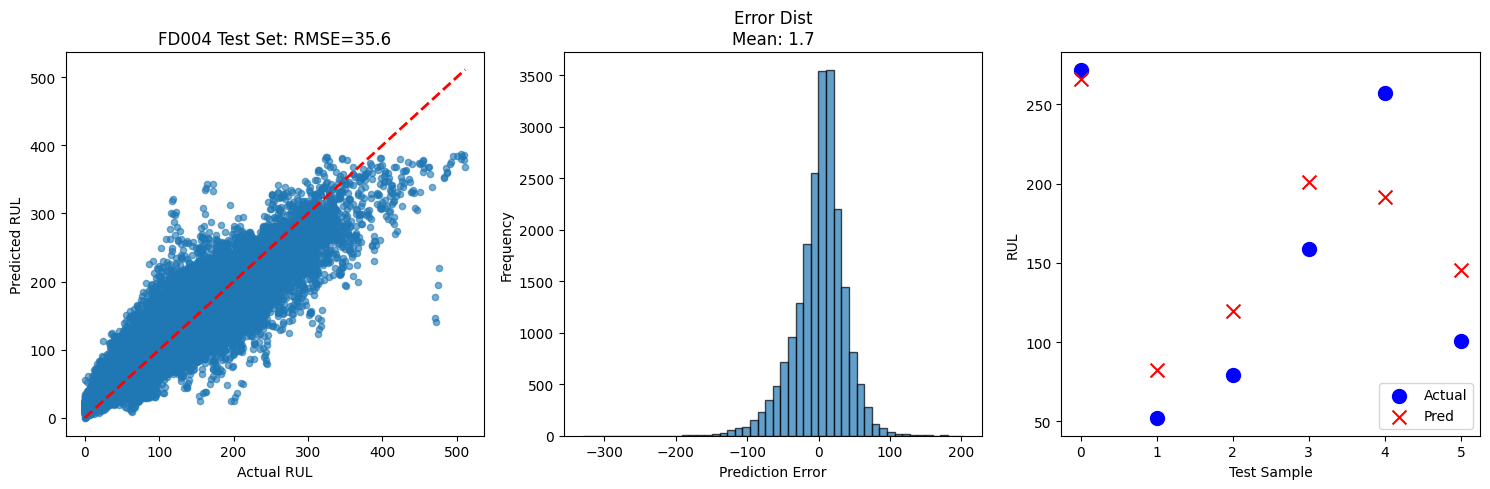

✅ FD004 plots saved!


In [57]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

# Plot 1: Predicted vs Actual RUL
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_test_pred, alpha=0.6, s=20)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual RUL'); plt.ylabel('Predicted RUL')
plt.title(f'FD004 Test Set: RMSE={test_rmse:.1f}')

# Plot 2: Error Distribution
plt.subplot(1, 3, 2)
errors = y_test_pred - y_test
plt.hist(errors, bins=50, alpha=0.7, edgecolor='black')
plt.xlabel('Prediction Error'); plt.ylabel('Frequency')
plt.title(f'Error Dist\nMean: {errors.mean():.1f}')

# Plot 3: Sample Predictions (first 30)
plt.subplot(1, 3, 3)
for i in range(0, 30, 5):
    plt.scatter(i//5, y_test[i], c='blue', s=100, label='Actual' if i==0 else "")
    plt.scatter(i//5, y_test_pred[i], c='red', marker='x', s=100, label='Pred' if i==0 else "")
plt.xlabel('Test Sample'); plt.ylabel('RUL')
plt.legend()

plt.tight_layout()
plt.savefig('fd004_evaluation_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ FD004 plots saved!")


In [58]:
import pandas as pd

def classify_alert(rul):
    if rul < 10: return 'CRITICAL'
    elif rul < 30: return 'WARNING'
    elif rul < 125: return 'SAFE'
    return 'VERY_SAFE'

# Generate alerts for all test predictions
alert_levels = [classify_alert(r) for r in y_test_pred]

# Alert distribution
df_alerts = pd.DataFrame({
    'actual_rul': y_test,
    'predicted_rul': y_test_pred,
    'alert_level': alert_levels
})

print("FD004 Alert Distribution:")
print(df_alerts['alert_level'].value_counts().sort_index())
print(f"Average actual RUL by alert:")
print(df_alerts.groupby('alert_level')['actual_rul'].mean().round(1))


FD004 Alert Distribution:
alert_level
CRITICAL       79
SAFE         9805
VERY_SAFE    9550
WARNING      2078
Name: count, dtype: int64
Average actual RUL by alert:
alert_level
CRITICAL       4.1
SAFE          76.7
VERY_SAFE    188.1
WARNING       14.5
Name: actual_rul, dtype: float64


In [59]:
# Save evaluation results
np.savez('fd004_evaluation.npz', 
         y_test=y_test, 
         y_test_pred=y_test_pred, 
         rmse=test_rmse, 
         mae=test_mae)

# Save alerts
np.savez('fd004_alerts.npz', 
         alerts=np.array(alert_levels, dtype=object),
         thresholds={'critical':10, 'warning':30, 'safe':125})

print("🎉 FD004 ALL MILESTONES COMPLETE!")
print("✅ Files saved:")
print("📁 ALL FD001-FD004 FILES READY FOR MASTER DASHBOARD!")


🎉 FD004 ALL MILESTONES COMPLETE!
✅ Files saved:
📁 ALL FD001-FD004 FILES READY FOR MASTER DASHBOARD!
